# Natural Computing - Project
#### Submission by group 25 (Chihab Amghane, Max Driessen, Jordy Naus)

The code below uses the DEAP framework (https://github.com/deap/deap), which is a very intuitive framework for evolutionary algorithms and genetic programming.

## Installing required packages

In [1]:
# !pip install deap
# !pip install tensorflow
# !pip install scikit-image

## Imports

In [2]:
from deap import gp, base, tools, creator, algorithms
from tensorflow.keras.datasets import mnist
from skimage.transform import rescale
import matplotlib.pyplot as plt
import numpy as np
import operator
import math

%matplotlib inline

## Global parameters

In [3]:
# Dataset parameters
STANDARD_IMAGE_SIZE = 28
DESIRED_IMAGE_SIZE = 16
N_CLASSES_TO_USE = 4

# Individual tree parameters
MAX_ARITY = 10
MIN_INITIAL_DEPTH = 3
MAX_INITIAL_DEPTH = 5

# Population parameters
POPULATION_SIZE = 100

# Fitness parameters
N_SAMPLES_TO_TEST = 50

# Evolution parameters
CONTROL_BLOAT = True
P_CROSSOVER_PER_TREE = 1.0
P_CROSSOVER = 1.0
P_MUTATION_PER_TREE = 0.0
P_MUTATION = 0.0
N_GENERATIONS = 100

In [4]:
# Parameters that depend on other parameters
RESCALE_FACTOR = DESIRED_IMAGE_SIZE/STANDARD_IMAGE_SIZE
N_PIXELS = DESIRED_IMAGE_SIZE**2

## Loading & preprocessing data

##### Downloading

In [5]:
# Loading the data
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

##### Removing classes

In [6]:
# Ensure correct number of classes
X_train = X_train[Y_train < N_CLASSES_TO_USE]
Y_train = Y_train[Y_train < N_CLASSES_TO_USE]
X_test = X_test[Y_test < N_CLASSES_TO_USE]
Y_test = Y_test[Y_test < N_CLASSES_TO_USE]

In [7]:
# Extract and print the number of training and testing samples remaining
n_samples_train = X_train.shape[0]
n_samples_test = X_test.shape[0]
print(f"Training samples remaining: {n_samples_train}")
print(f"Testing samples remaining: {n_samples_test}")

Training samples remaining: 24754
Testing samples remaining: 4157


##### Rescaling

In [8]:
# Rescaling to the desired size
def rescale_images(images, do_anti_aliasing=False):
    return np.array([rescale(image, RESCALE_FACTOR, anti_aliasing=do_anti_aliasing) for image in images])

# Rescale X_train and X_test
X_train_small = rescale_images(X_train)
X_test_small = rescale_images(X_test)

##### Normalization

In [9]:
# Normalize the data
def normalize(images):
    return (images - np.mean(images, axis=0))/(np.std(images, axis=0) + 0.000001)

# Normalize X_train_small and X_test_small
X_train_norm = normalize(X_train_small)
X_test_norm = normalize(X_test_small)

##### Visualizing the process

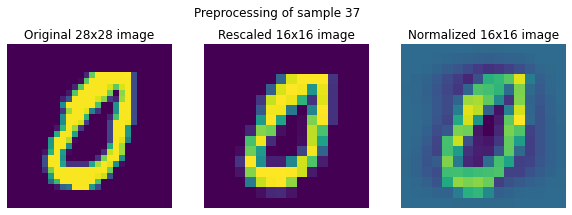

In [10]:
# Plot original and reshaped image
def plot_comparison(idx_to_plot, lists, titles):
    n_plots = len(lists)
    fig, ax = plt.subplots(1,n_plots, figsize=(10,10/n_plots))
    for i in range(n_plots):
        ax[i].imshow(lists[i][idx_to_plot])
        ax[i].set_title(titles[i])
        ax[i].axis("off")
    fig.suptitle(f"Preprocessing of sample {idx_to_plot}",y=1)
    plt.show()
    
plot_comparison(37,
                [X_train, X_train_small, X_train_norm],
                [f"Original {STANDARD_IMAGE_SIZE}x{STANDARD_IMAGE_SIZE} image",
                 f"Rescaled {DESIRED_IMAGE_SIZE}x{DESIRED_IMAGE_SIZE} image",
                 f"Normalized {DESIRED_IMAGE_SIZE}x{DESIRED_IMAGE_SIZE} image"])

In [11]:
# Replace and reshape X_train and X_test, for convenience
X_train = X_train_norm.reshape(n_samples_train, DESIRED_IMAGE_SIZE**2)
X_test = X_test_norm.reshape(n_samples_test, DESIRED_IMAGE_SIZE**2)

## Defining operators

In [12]:
# Create set of functions and terminals, with one terminal for each pixel
pset = gp.PrimitiveSet("main", DESIRED_IMAGE_SIZE**2)

In [13]:
# Define operators (with a variable number of inputs)
def linear(*args):
    return sum(args)

def inverse(*args):
    return -sum(args)

def tanh(*args):
    return math.tanh(sum(args))

def sigmoid(*args):
    return 1.0/(1.0 + math.exp(-sum(args)))

def step(*args):
    return float(sum(args) >= 0)

def sine(*args):
    return math.sin(sum(args))

def cosine(*args):
    return math.cos(sum(args))

def gaussian(*args):
    return 0.5*sum(args)*(1.0+math.tanh(math.sqrt(2.0/math.pi)*(sum(args) + 0.044715*sum(args)**3)))
                          
def absolute(*args):
    return abs(sum(args))

In [14]:
# Add operators to the set (using a "hacky" solution to allow variable arities)
for arity in range(1, MAX_ARITY+1):
    pset.addPrimitive(linear, arity)
    pset.addPrimitive(inverse, arity)
    pset.addPrimitive(tanh, arity)
    pset.addPrimitive(sigmoid, arity)
    pset.addPrimitive(step, arity)
    pset.addPrimitive(sine, arity)
    pset.addPrimitive(cosine, arity)
    pset.addPrimitive(gaussian, arity)
    pset.addPrimitive(absolute, arity)

## Defining individuals

In [15]:
# Intialize the toolbox which will contain all sorts of functions for the genetic programming process
toolbox = base.Toolbox()

In [16]:
# Define how to create a random expression/tree (using half-and-half intialization)
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=MIN_INITIAL_DEPTH, max_=MAX_INITIAL_DEPTH)

In [17]:
# Define classes for fitness, trees and individuals (using DEAP's creator module)
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Tree", gp.PrimitiveTree)
creator.create("Individual", list, fitness=creator.FitnessMin)

In [18]:
# Define how to initialize a tree, individual or population
toolbox.register("tree", tools.initIterate, creator.Tree, toolbox.expr)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.tree, N_CLASSES_TO_USE)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

## Fitness function

In [19]:
# Define how to compile a single tree and an individual
toolbox.register("compile_tree", gp.compile, pset=pset)
toolbox.register("compile_individual", lambda individual: [toolbox.compile_tree(t) for t in individual])

In [20]:
# Define fitness function
def fitness(individual, n_samples_to_test):
    # Compile the functions corresponding to the individual
    funcs = toolbox.compile_individual(individual)
    
    # Define how to compute softmax and cross-entropy
    def softmax(x):
        return np.exp(x)/np.sum(np.exp(x), axis=0)
    def cross_entropy(pred, label):
        return -np.log(np.exp(pred[label])/np.sum(np.exp(pred), axis=0))
    
    # Compute the cross-entropy loss for a given number of samples
    losses = []
    sample_indices = np.random.permutation(range(n_samples_train))[:n_samples_to_test]
    for i in sample_indices:
        X_sample, Y_sample = X_train[i], Y_train[i]
        output = softmax([f(*X_sample) for f in funcs])
        losses.append(cross_entropy(output, Y_sample))
    
    # Return the average cross-entropy loss
    return (np.average(losses),)

In [21]:
# Add the fitness function to the toolbox
toolbox.register("evaluate", fitness, n_samples_to_test=N_SAMPLES_TO_TEST)

## Evolution components

##### Parent selection

In [22]:
# Define how to select parents (tournament selection; either controlling for bloat or not controlling for it)
if CONTROL_BLOAT:
    toolbox.register("select", tools.selDoubleTournament, fitness_size=3, parsimony_size=1.3, fitness_first=False)
else:
    toolbox.register("select", tools.selTournament, tournsize=3)

##### Crossover

In [23]:
# Define how to perform crossover
def crossover(ind1, ind2):
    new_ind1, new_ind2 = [], []
    for i in range(N_CLASSES_TO_USE):
        tree1, tree2 = ind1[i], ind2[i]
        if np.random.random() < P_CROSSOVER_PER_TREE:
            tree1, tree2 = gp.cxOnePoint(tree1, tree2)
        new_ind1.append(tree1)
        new_ind2.append(tree2)
    return (creator.Individual(new_ind1), creator.Individual(new_ind2))

In [24]:
# Add the crossover ("mating") function to the toolbox
toolbox.register("mate", crossover)

##### Mutation

##### Height boundary

## Statistics

In [25]:
# OLD!
# Functions for determining average, min and max, which control for the possibility that the input might consist of tuples
def tuple_avg(a):
    if len(a[0]) == 2:
        return np.mean([x[0] for x in a])
    return np.mean(a)

def tuple_min(a):
    if len(a[0]) == 2:
        return np.min([x[0] for x in a])
    return np.min(a)

def tuple_max(a):
    if len(a[0]) == 2:
        return np.max([x[0] for x in a])
    return np.max(a)

# Function for determining the size of the agent with the best fitness
def tuple_best_size(a):
    if len(a[0]) == 2:
        return np.amax(a, 1)[0]
    return None

In [26]:
# OLD!
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(lambda ind: [len(ind), ind.fitness.values[0]])
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg",  tuple_avg)
mstats.register("min",  tuple_min)
mstats.register("max",  tuple_max)
mstats.register("best", tuple_best_size)

## Running the genetic programming algorithm

In [27]:
# OLD!
pop = toolbox.population(POPULATION_SIZE)
hof = tools.HallOfFame(1)
pop, log = algorithms.eaSimple(population=pop, 
                               toolbox=toolbox, 
                               cxpb=P_CROSSOVER, 
                               mutpb=P_MUTATION, 
                               ngen=N_GENERATIONS, 
                               stats=mstats, 
                               halloffame=hof, 
                               verbose=True)

   	      	                   fitness                    	                     size                     
   	      	----------------------------------------------	----------------------------------------------
gen	nevals	avg    	best	gen	max    	min    	nevals	avg	best	gen	max	min	nevals
0  	100   	1.46348	None	0  	1.69428	1.26756	100   	4  	4   	0  	4  	4  	100   
1  	100   	1.43548	None	1  	1.61579	1.25018	100   	4  	4   	1  	4  	4  	100   
2  	100   	1.42009	None	2  	1.63331	1.22402	100   	4  	4   	2  	4  	4  	100   
3  	100   	1.38074	None	3  	1.57333	1.22548	100   	4  	4   	3  	4  	4  	100   
4  	100   	1.34033	None	4  	1.51203	1.03494	100   	4  	4   	4  	4  	4  	100   
5  	100   	1.32137	None	5  	1.44763	1.16788	100   	4  	4   	5  	4  	4  	100   
6  	100   	1.31073	None	6  	1.47297	1.1895 	100   	4  	4   	6  	4  	4  	100   
7  	100   	1.29618	None	7  	1.43028	1.16886	100   	4  	4   	7  	4  	4  	100   
8  	100   	1.28599	None	8  	1.45132	1.14668	100   	4  	4   	8  	4  	4  	100   


100	100   	1.12671	None	100	1.29233	0.996113	100   	4  	4   	100	4  	4  	100   
